In [1]:
## imports

import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle

import cartopy
import cartopy.crs as ccrs
import cftime
import datetime

import xskillscore as xs

%load_ext autoreload
%autoreload 2

In [2]:
# Import functions from defs.py

from defs import lowess

In [3]:
def remove_regression(data, mode="linearfit", nyear = 30):
    
    time = xr.DataArray(data = np.arange(len(data.time)), dims = "time", coords = data.time.coords)

    if mode == "linearfit":
        
        slope  = xs.linslope(time, data, dim="time")
        linfit = slope * time - (slope * time).mean("time")
        
        anomalies = data - linfit;
        
    elif mode == "lowess":
        
        alpha = nyear * 12 / len(data.time)
        curve = lowess(data, dim = "time", alpha = alpha, it = 1); 
        
        anomalies = data - (curve - curve.mean("time"));
            
    return anomalies

In [16]:
kgms_2_mmday = 86400;

# load reanalysis
ds_pr_obs = xr.open_dataset('Reanalysis/prate.mon.mean.nc')

# select 100 years overlapping (1916-2015)
pr_obs = ds_pr_obs.prate.sel(time=slice('1916-01-01', '2015-12-01')).sortby("lat")
pr_obs = kgms_2_mmday * pr_obs

# select extended central - North Pacific region
pr_obs = pr_obs.sel(lat = slice(-20, 80)).sel(lon = slice(120, 280))

# remove monthly means (first time)
pra_obs = pr_obs.groupby('time.month') - pr_obs.groupby('time.month').mean('time')

# remove linear / lowess filter  per lat /lon (skip SST land)
pra_obs_det = remove_regression(pra_obs, "lowess", 50)

# Remove monthly means (again, to remove possible residual)
pra_obs_det = pra_obs_det.groupby('time.month') - pra_obs_det.groupby('time.month').mean('time')

# give some information
pra_obs_det.attrs["Units"]      = "mm/day"
pra_obs_det.attrs["Reanalysis"] = "Monthly NOAA/CIRES/DOE 20th Century Reanalysis V3"
pra_obs_det.attrs["Detrending"] = "lowess 50y"

ds_prpa_obs = pra_obs_det.to_dataset(name = "prect")
ds_prpa_obs.to_netcdf("Reanalysis/prect_CR20_1916_2015_lowess.nc")


In [149]:

# load reanalysis
ds_slp_obs = xr.open_dataset('Reanalysis/prmsl.mon.mean.nc')
ds_sst_obs = xr.open_dataset('Reanalysis/sst.mnmean.nc')


# select 100 years overlapping (1916-2015)
sst_obs =      ds_sst_obs.sst.sel(time=slice('1916-01-01', '2015-12-01')).sortby("lat")
slp_obs = 0.01*ds_slp_obs.prmsl.sel(time=slice('1916-01-01', '2015-12-01')).sortby("lat")


# select extended central - North Pacific region
sst_obs = sst_obs.sel(lat = slice(-20, 80)).sel(lon = slice(120, 280))
slp_obs = slp_obs.sel(lat = slice(-20, 80)).sel(lon = slice(120, 280))


# remove monthly means (first time)
ssta_obs = sst_obs.groupby('time.month') - sst_obs.groupby('time.month').mean('time')
slpa_obs = slp_obs.groupby('time.month') - slp_obs.groupby('time.month').mean('time')


# remove linear / lowess filter  per lat /lon (skip SST land)
ssta_obs_det = remove_regression(ssta_obs, "lowess", 50)
slpa_obs_det = remove_regression(slpa_obs, "lowess", 50)
# ssta_obs_det = remove_regression(ssta_obs, "linearfit")
# slpa_obs_det = remove_regression(slpa_obs, "linearfit")


# Remove monthly means (again, to remove possible residual)
ssta_obs_det = ssta_obs_det.groupby('time.month') - ssta_obs_det.groupby('time.month').mean('time')
slpa_obs_det = slpa_obs_det.groupby('time.month') - slpa_obs_det.groupby('time.month').mean('time')


# give some information
ssta_obs_det.attrs["Units"]      = "deg C"
ssta_obs_det.attrs["Reanalysis"] = "NOAA Extended Reconstructed Sea Surface Temperature (ERSST) v5"
ssta_obs_det.attrs["Detrending"] = "lowess 50y"
# ssta_obs_det.attrs["Detrending"] = "linear fit"

slpa_obs_det.attrs["Units"]      = "hPa"
slpa_obs_det.attrs["Reanalysis"] = "Monthly NOAA/CIRES/DOE 20th Century Reanalysis V3"
slpa_obs_det.attrs["Detrending"] = "lowess 50y"
# slpa_obs_det.attrs["Detrending"] = "linear fit"


# save reanalysis process anomalies
ds_ssta_obs = ssta_obs_det.to_dataset(name = "SST")
ds_ssta_obs.to_netcdf("Reanalysis/SST_ERSST_1916_2015_lowess.nc")
# ds_ssta_obs.to_netcdf("Reanalysis/SST_ERSST_1916_2015_linear.nc")

ds_slpa_obs = slpa_obs_det.to_dataset(name = "SLP")
ds_slpa_obs.to_netcdf("Reanalysis/SLP_CR20_1916_2015_lowess.nc")
# ds_slpa_obs.to_netcdf("Reanalysis/SLP_CR20_1916_2015_linear.nc")



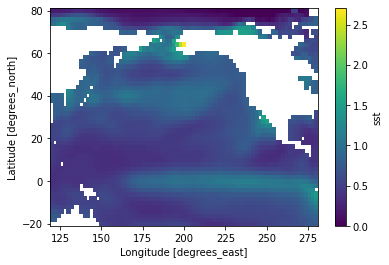

In [119]:
ssta_obs.std("time").plot()#vmin=0, vmax=1.2)

In [127]:
NINO1  = ssta_obs.sel(lat=slice(-5,5)).sel(lon=slice(190,240)).mean("lat").mean("lon")
NINO2  = ssta_obs_det.sel(lat=slice(-5,5)).sel(lon=slice(190,240)).mean("lat").mean("lon")

ALI1   = slpa_obs.sel(lat=slice(30, 65)).sel(lon=slice(160, 220)).mean("lat").mean("lon")
ALI2   = slpa_obs_det.sel(lat=slice(30, 65)).sel(lon=slice(160, 220)).mean("lat").mean("lon")

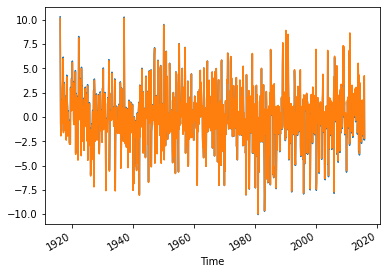

In [128]:
# NINO1.plot()
# NINO2.plot()

ALI1.plot()
ALI2.plot()

In [132]:
ALI2.std()

<xarray.DataArray ()>
array(2.72253116)